In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras import models, layers, Input, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

from sklearn.feature_extraction.text import CountVectorizer

In [22]:
# Functions

## function to setup model - assuming multiclass classification problem
def setup_model(topo, dropout_rate, input_size, output_size):
    model = Sequential()
    model.add(Input( (input_size, ) ))
    model.add(Dense(topo[0], activation="relu") )
    if dropout_rate > 0: model.add(Dropout(dropout_rate))
    for i in range(1,len(topo)):
        model.add(Dense(topo[i], activation="relu"))
        if dropout_rate > 0: model.add(Dropout(dropout_rate))
    model.add(Dense(output_size))
    model.add(Activation('softmax')) # TODO mudar para cross-entropy

    return model

## training the DNN - takes algorithm (string) and learning rate; data (X, y), epochs and batch size
def train_dnn(model, alg, lr, Xtrain, Ytrain, epochs = 5, batch_size = 64):
    if alg == "adam":
        optimizer = optimizers.Adam(learning_rate = lr)
    elif alg == "rmsprop":
        optimizer = optimizers.RMSprop(learning_rate = lr)
    elif alg == "sgd_momentum":
        optimizer = optimizers.SGD(learning_rate = lr, momentum = 0.9)
    else: optimizer = optimizers.SGD(learning_rate = lr)

    model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
    model.fit(Xtrain, Ytrain, epochs = epochs, batch_size = batch_size, verbose = 0)

    return model

## optimizing parameters: topology, algorithm, learning rate, dropout
## randomized search optimization with maximum iterations
## takes as input: dictionary with params to optimizae and possible values; training data(X,y), validation data (X,y), iterations, epochs for training
def dnn_optimization(opt_params, Xtrain, Ytrain, Xval, Yval, iterations = 10, epochs = 5, verbose = True):
    from random import choice

    if verbose:
        print("Topology\tDropout\tAlgorithm\tLRate\tValLoss\tValAcc\n")
    best_acc = None
    best_config = None

    # TODO Error because Ytrain.shape = (12000,)
    input_size = Xtrain.shape[1]
    output_size = Ytrain.shape[1] # TODO mudar 1

    if "topology" in opt_params:
        topologies = opt_params["topology"]
    else: topologies = [[100]]
    if "algorithm" in opt_params:
        algs = opt_params["algorithm"]
    else: algs = ["adam"]
    if "lr" in opt_params:
        lrs = opt_params["lr"]
    else: lrs = [0.001]
    if "dropout" in opt_params:
        dropouts = opt_params["dropout"]
    else: dropouts= [0.0]

    for it in range(iterations):
        topo = choice(topologies)
        dropout_rate = choice(dropouts)
        dnn = setup_model (topo, dropout_rate, input_size, output_size)
        alg = choice(algs)
        lr = choice(lrs)
        dnn = train_dnn(dnn, alg, lr, Xtrain, Ytrain, epochs, 128)
        val_loss, val_acc = dnn.evaluate(Xval, Yval, verbose = 0)

        if verbose:
            print(topo, "\t", dropout_rate, "\t", alg, "\t", lr, "\t", val_loss, "\t", val_acc)

        if best_acc is None or val_acc > best_acc:
            best_acc = val_acc
            best_config = (topo, dropout_rate, alg, lr)

    return best_config, best_acc

In [6]:
# Import Data

train = pd.read_csv('../../Dataset/dataset_training_small.csv', sep=';')
test = pd.read_csv('../../Dataset/dataset_test_small.csv', sep=';')
validation = pd.read_csv('../../Dataset/dataset_validation_small.csv', sep=';')

In [7]:
# Preprocess data

vectorizer = CountVectorizer()

X_train = train.drop('ai_generator', inplace=False, axis=1)
vectorizer.fit(X_train['text'])
X_train = vectorizer.transform(X_train['text']).toarray()

y_train = train['ai_generator']
y_train = y_train.to_numpy()

X_test = test.drop('ai_generator', inplace=False, axis=1)
X_test = vectorizer.transform(X_test['text']).toarray()

y_test = test['ai_generator']
y_test = y_test.to_numpy()

X_validation = validation.drop('ai_generator', inplace=False, axis=1)
X_validation = vectorizer.transform(X_validation['text']).toarray()

y_validation = validation['ai_generator']
y_validation = y_validation.to_numpy()

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 328ms/step - acc: 0.8144 - loss: 0.4219 - val_acc: 0.9963 - val_loss: 0.0946
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - acc: 0.9954 - loss: 0.0704 - val_acc: 0.9990 - val_loss: 0.0295
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - acc: 0.9995 - loss: 0.0225 - val_acc: 0.9998 - val_loss: 0.0104
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.9997 - loss: 0.0093 - val_acc: 1.0000 - val_loss: 0.0054
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 1.0000 - loss: 0.0042 - val_acc: 1.0000 - val_loss: 0.0023
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - acc: 1.0000 - loss: 0.0019 - val_acc: 1.0000 - val_loss: 0.0011
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - acc: 1.0000 - loss: 9.8057e-04 - val_acc: 1.0000 - val_loss: 6.6419e-04
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 1.0000 - loss: 5.8204e-04 - val_acc: 1.0000 - val_loss: 3.8089e-04
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/

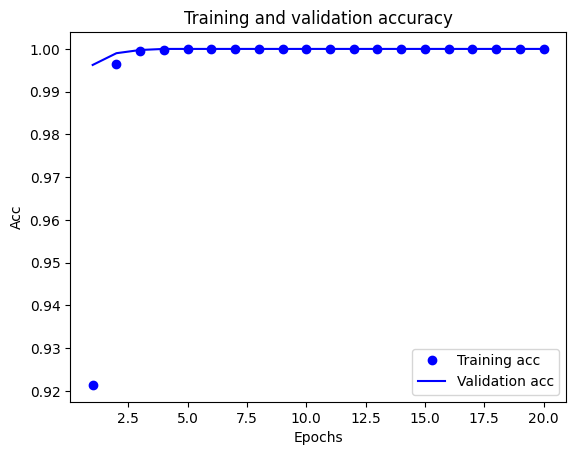

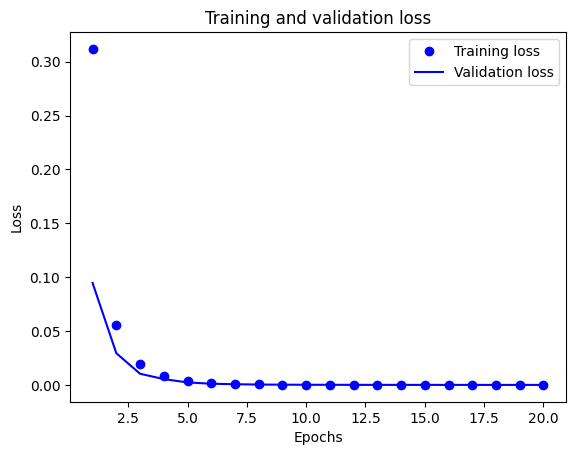

[3.113520870101638e-05, 1.0]

In [8]:
# Build Simple Model

hidden = 16

n_features = X_train.shape[1]

model = models.Sequential()
model.add(Input((n_features,)))
model.add(layers.Dense(hidden, activation='relu'))
model.add(layers.Dense(hidden, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Train Model

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, epochs=20, batch_size=512, validation_data=(X_validation, y_validation))

# Plot accuracy curves

history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

# Plot loss curves

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate Model
results = model.evaluate(X_test, y_test, verbose = 0)
results

# Extreme low loss and perfect accuracy
# Perguntar ao stor o que significa

In [23]:
# Optimize Model

opt_pars = {"topology":[[100], [100,50], [250], [250,100]],
            "algorithm": [ "adam", "rmsprop", "sgd_momentum"],
            "lr": [0.01, 0.001],
            "dropout": [0, 0.2, 0.5]}

best_config, best_val_acc = dnn_optimization(opt_pars, X_train, y_train, X_validation, y_validation, iterations = 20, epochs = 20)
print("Best configuration:", best_config)
print("Best validation accuracy:", best_val_acc)

# take best configuration and retrain with whole training set
# evaluate error on holdout test set
best_model = setup_model(best_config[0], best_config[1], X_train.shape[1], y_train.shape[1])
best_model = train_dnn(best_model, best_config[2], best_config[3], X_train, y_train)

test_loo, test_acc = best_model.evaluate(X_test, y_test, verbose = 0)
print("Test set metrics:", test_loo, test_acc)

Topology	Dropout	Algorithm	LRate	ValLoss	ValAcc



ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_16" is incompatible with the layer: expected axis -1 of input shape to have value 12000, but received input with shape (None, 21611)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 21611), dtype=int64)
  • training=True
  • mask=None